## Gas & Oil Price

In [184]:
target_list = ['GAS_PRICE', 'OIL_PRICE', 'RP']

In [185]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

from datetime import timedelta
import torch
from torch import nn
from torch import optim
from torch.utils.data import DataLoader, Dataset

from tqdm.auto import tqdm
import pickle

from models.model import Informer
from utils.timefeatures import time_features
from data.data_loader import Dataset_Pred

In [186]:
targetData = pd.read_csv("~/Desktop/final/0_data/newdata/new_df_00_rp3.csv")
targetData.tail()

,date,year,month,GAS_PRICE,OIL_PRICE,도시가스_민수용,도시가스_산업용,도시가스_총합,민수용비중,산업용비중,...,명GDP0.8성장율,명0.8누적성장율,QVA_origin,yearmonth,holirate,month4,month3,cumhouse,kospi_float,RP
463,2034-08-01,2034,8,83.799259,176.290845,NaN,NaN,NaN,NaN,NaN,...,0.8,154.8,177197.113983,203408,0.290323,0,0,2.109693e+07,2914.478097,0.585510
464,2034-09-01,2034,9,86.812957,176.091156,NaN,NaN,NaN,NaN,NaN,...,0.8,154.8,177574.496755,203409,0.400000,2,0,2.257263e+07,2911.642185,0.580533
465,2034-10-01,2034,10,88.765294,176.477153,NaN,NaN,NaN,NaN,NaN,...,0.8,154.8,177952.683253,203410,0.354839,2,1,2.481591e+07,2909.004839,0.567519
466,2034-11-01,2034,11,81.522757,180.507672,NaN,NaN,NaN,NaN,NaN,...,0.8,154.8,178331.675187,203411,0.266667,2,1,2.642817e+07,2924.459443,0.568239
467,2034-12-01,2034,12,77.097869,177.032984,NaN,NaN,NaN,NaN,NaN,...,0.8,154.8,178711.474274,203412,0.354839,3,2,2.429100e+07,2943.309238,0.592368


In [187]:
originData = pd.read_csv("~/Desktop/final/0_data/newdata/new_df_00.csv")
originData = originData.copy()[:300]
originData.tail()

,date,year,month,RP,GAS_PRICE,OIL_PRICE,도시가스_민수용,도시가스_산업용,도시가스_총합,민수용비중,...,명누적성장율,명GDP0.8성장율,명0.8누적성장율,QVA_origin,yearmonth,holirate,month4,month3,cumhouse,kospi_float
295,2020-08-01,2020,8,0.86,72.93,84.71,398661.0,457970.0,856631.0,0.46538,...,143.6,0.8,143.6,121747.5,202008,0.064516,0,0,12943215.0,2326.17
296,2020-09-01,2020,9,0.80,65.24,81.26,380235.0,525619.0,905853.0,0.41975,...,143.6,0.8,143.6,121747.5,202009,0.033333,2,0,12943215.0,2327.89
297,2020-10-01,2020,10,0.76,59.16,78.13,616682.0,600890.0,1217571.0,0.50649,...,143.6,0.8,143.6,124740.4,202010,0.129032,2,1,12943215.0,2267.15
298,2020-11-01,2020,11,0.75,58.72,78.64,1093747.0,665901.0,1759648.0,0.62157,...,143.6,0.8,143.6,124740.4,202011,0.000000,2,1,12943215.0,2591.34
299,2020-12-01,2020,12,0.72,63.87,88.53,1921404.0,811928.0,2733332.0,0.70295,...,143.6,0.8,143.6,124740.4,202012,0.032258,3,2,12943215.0,2873.47


In [188]:
res_df = pd.DataFrame({'date':pd.date_range('1996-01-01','2034-12-01',freq='MS')})
res_df

,date
0,1996-01-01
1,1996-02-01
2,1996-03-01
3,1996-04-01
4,1996-05-01
...,...
463,2034-08-01
464,2034-09-01
465,2034-10-01
466,2034-11-01


In [189]:
pred_len = 84
iter = 2 # 반복수

seq_len = 100 #인풋 크기
label_len = 100 #디코더에서 참고할 크기
pred_len = pred_len#예측할 크기

batch_size = 1
shuffle_flag = False
num_workers = 0
drop_last = False
device = torch.device("cuda:0")
# device = torch.device("cuda" if torch.cuda.is_available() else 'cpu')

In [190]:
def _process_one_batch(batch_x, batch_y, batch_x_mark, batch_y_mark):
    batch_x = batch_x.float().to(device)
    batch_y = batch_y.float()
    batch_x_mark = batch_x_mark.float().to(device)
    batch_y_mark = batch_y_mark.float().to(device)
    dec_inp = torch.zeros([batch_y.shape[0], pred_len, batch_y.shape[-1]]).float()
    dec_inp = torch.cat([batch_y[:,:label_len,:], dec_inp], dim=1).float().to(device)
    outputs = model(batch_x, batch_x_mark, dec_inp, batch_y_mark)
    batch_y = batch_y[:,-pred_len:,0:].to(device)
    return outputs, batch_y

In [196]:
def InformerRes(start_year, start_month, add_year, add_month, start_plot, iter, pitcher_list, data_train, targetName, res_df):
  for _ in tqdm(range(iter), leave=True, desc='iter'):
      min_max_scaler = MinMaxScaler()
      for column in pitcher_list:
        data_train[column] = min_max_scaler.fit_transform(data_train[column].to_numpy().reshape(-1,1)).reshape(-1)

      dataset = Dataset_Pred(dataframe=data_train ,scale=True, size = (seq_len, label_len,pred_len))
      data_loader = DataLoader(dataset,batch_size=batch_size,shuffle=shuffle_flag,num_workers=num_workers,drop_last=drop_last)
        
      scaler = dataset.scaler
        
      for i, (batch_x,batch_y,batch_x_mark,batch_y_mark) in enumerate(data_loader):
        pred, true = _process_one_batch(batch_x, batch_y, batch_x_mark, batch_y_mark)
        
      preds = np.array(pred.detach().cpu().numpy())
      predDf = pd.DataFrame(preds[-1], columns = pitcher_list)

      last_month = start_month + add_month-1
      last_year = start_year + add_year-1

      if last_month > 12:
        last_year += 1
        last_month -= 12
      elif last_month == 0:
        last_month = 12

      scale_df = scaler.inverse_transform(predDf)

      month_df = pd.DataFrame({'date':pd.date_range(f'{start_year}-{start_month}-01', f'{last_year}-{last_month}-01',freq='MS')})
      merged_df = pd.concat([month_df, scale_df], axis=1)

      start_year = last_year
      start_month = last_month + 1

      if start_month > 12:
        start_year += 1
        start_month -= 12

      real = data_train["value"].to_numpy()

      real = min_max_scaler.inverse_transform(real.reshape(-1,1)).reshape(-1)
      result = min_max_scaler.inverse_transform(scale_df['value'].to_numpy().reshape(-1,1)).reshape(-1)
      plt.figure(figsize=(20,5))
      plt.plot(range(0,start_plot),real[:], label="real")
      plt.plot(range(start_plot, start_plot + pred_len ), result, label="predict")
      plt.legend()
      plt.show()

      start_plot = start_plot + pred_len

      data_train = data_train.append(merged_df)
      data_train = data_train.reset_index(drop=True)

      for column in pitcher_list:
        data_train[column] = min_max_scaler.inverse_transform(data_train[column].to_numpy().reshape(-1,1)).reshape(-1)  
      data_train
  
  data_train.rename(columns={'value':targetName},inplace=True)
  res_df = pd.concat([res_df, data_train[targetName]], axis=1)
  return res_df

In [197]:
def load_train_dataset(targetName):
  originData = pd.read_csv("~/Desktop/final/0_data/newdata/new_df_00.csv")
  originData["value"] = originData[targetName]
  originData = originData[['date', 'year', 'month', 'RP', 'GAS_PRICE', 'OIL_PRICE', '도시가스_민수용',
       '도시가스_산업용', '도시가스_총합', '민수용비중', '산업용비중', 'QUARTER', 'QVA',
       'temp_a_rcp6', 'temp_h_rcp6', 'temp_l_rcp6', 'people', '누적성장율',
       'QVA_origin', 'yearmonth', 'holirate', 'month3', 'cumhouse',
       'kospi_float', 'value']]
  originData = originData.drop(labels=targetName, axis=1)
  originData = originData.copy()[:300]
  col_list = list(originData.columns[1:])
  return originData, col_list

  0%|          | 0/3 [00:00<?, ?it/s]

['year', 'month', 'RP', 'OIL_PRICE', '도시가스_민수용', '도시가스_산업용', '도시가스_총합', '민수용비중', '산업용비중', 'QUARTER', 'QVA', 'temp_a_rcp6', 'temp_h_rcp6', 'temp_l_rcp6', 'people', '누적성장율', 'QVA_origin', 'yearmonth', 'holirate', 'month3', 'cumhouse', 'kospi_float', 'value']


iter:   0%|          | 0/2 [00:00<?, ?it/s]

1 False False


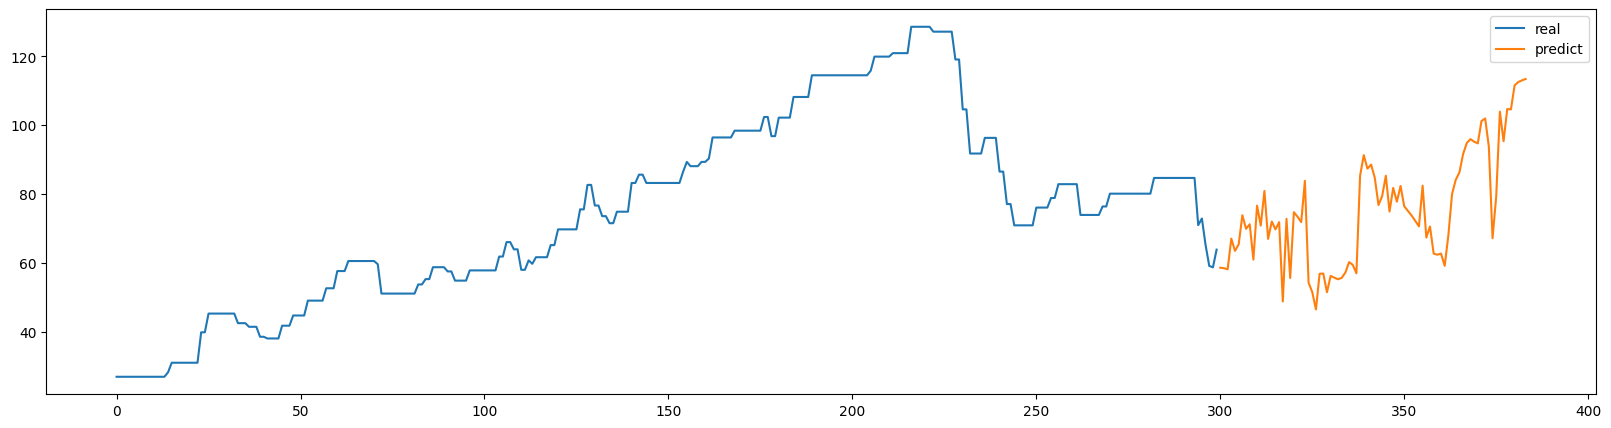

1 False False


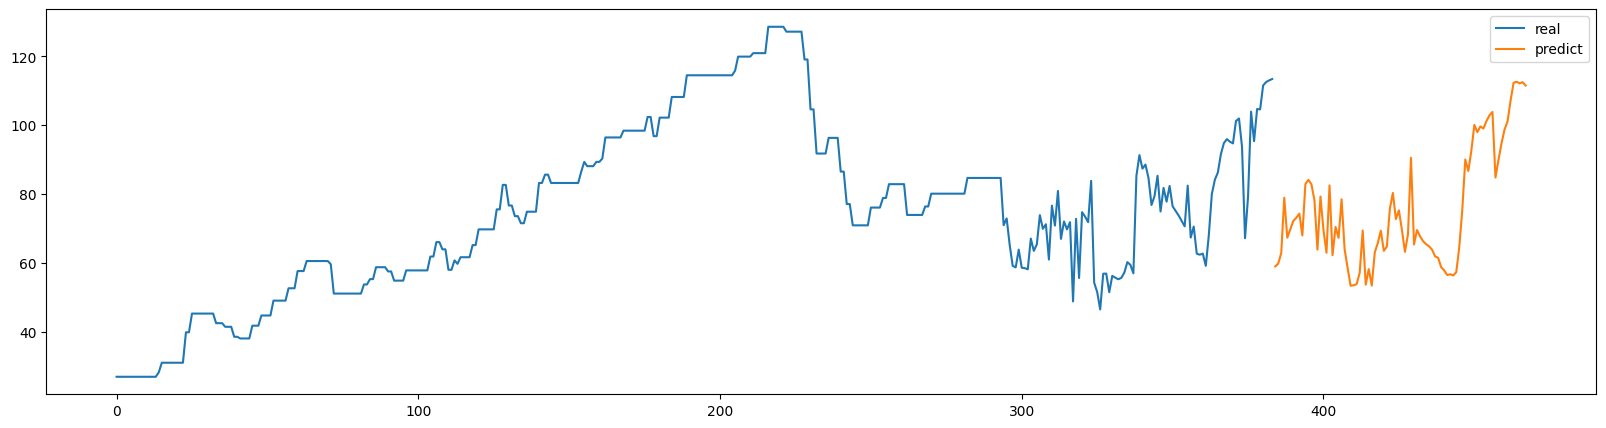

['year', 'month', 'RP', 'GAS_PRICE', '도시가스_민수용', '도시가스_산업용', '도시가스_총합', '민수용비중', '산업용비중', 'QUARTER', 'QVA', 'temp_a_rcp6', 'temp_h_rcp6', 'temp_l_rcp6', 'people', '누적성장율', 'QVA_origin', 'yearmonth', 'holirate', 'month3', 'cumhouse', 'kospi_float', 'value']


iter:   0%|          | 0/2 [00:00<?, ?it/s]

1 False False


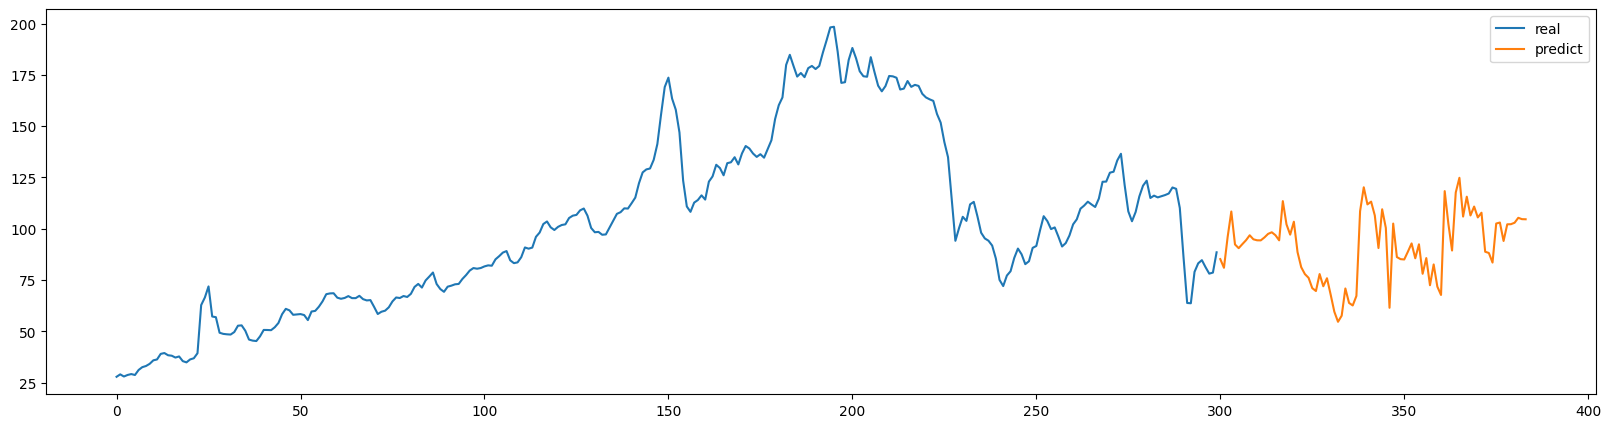

1 False False


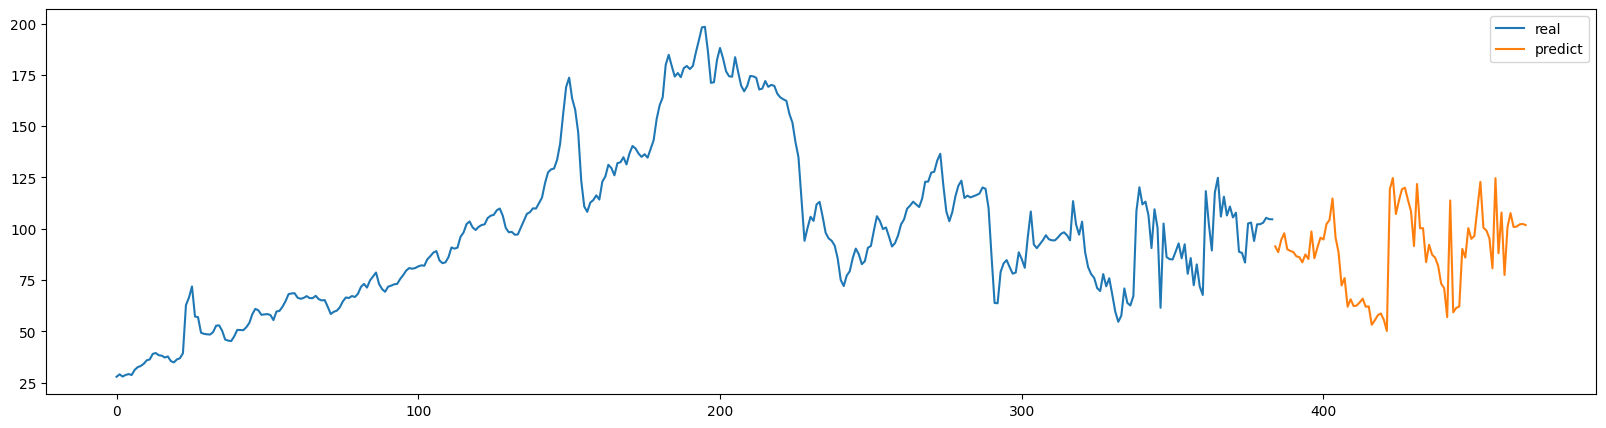

['year', 'month', 'GAS_PRICE', 'OIL_PRICE', '도시가스_민수용', '도시가스_산업용', '도시가스_총합', '민수용비중', '산업용비중', 'QUARTER', 'QVA', 'temp_a_rcp6', 'temp_h_rcp6', 'temp_l_rcp6', 'people', '누적성장율', 'QVA_origin', 'yearmonth', 'holirate', 'month3', 'cumhouse', 'kospi_float', 'value']


iter:   0%|          | 0/2 [00:00<?, ?it/s]

1 False False


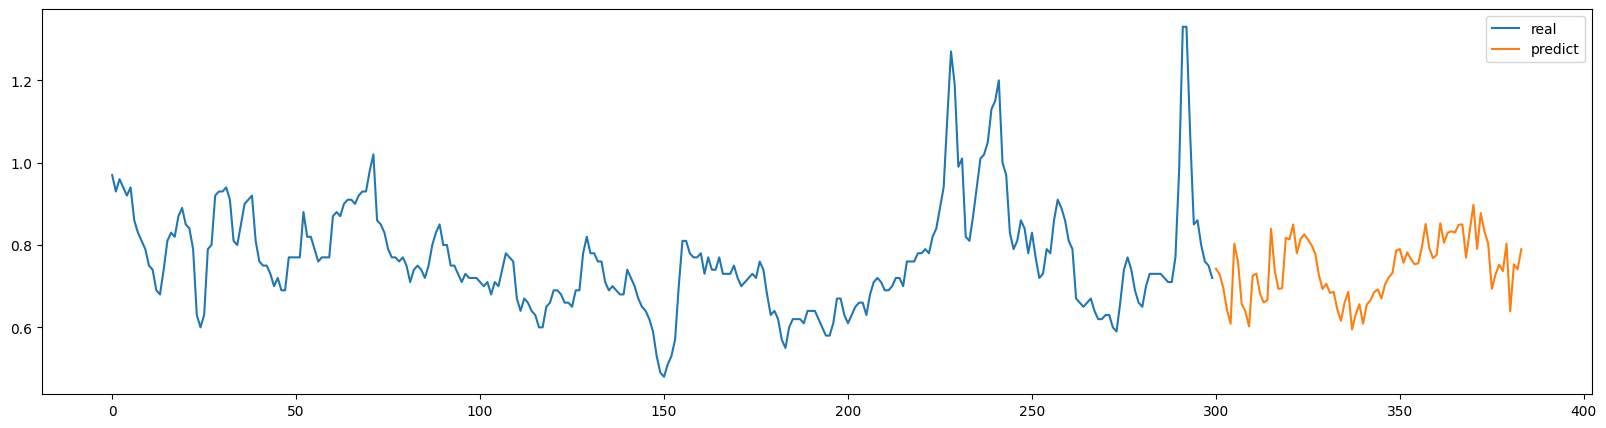

1 False False


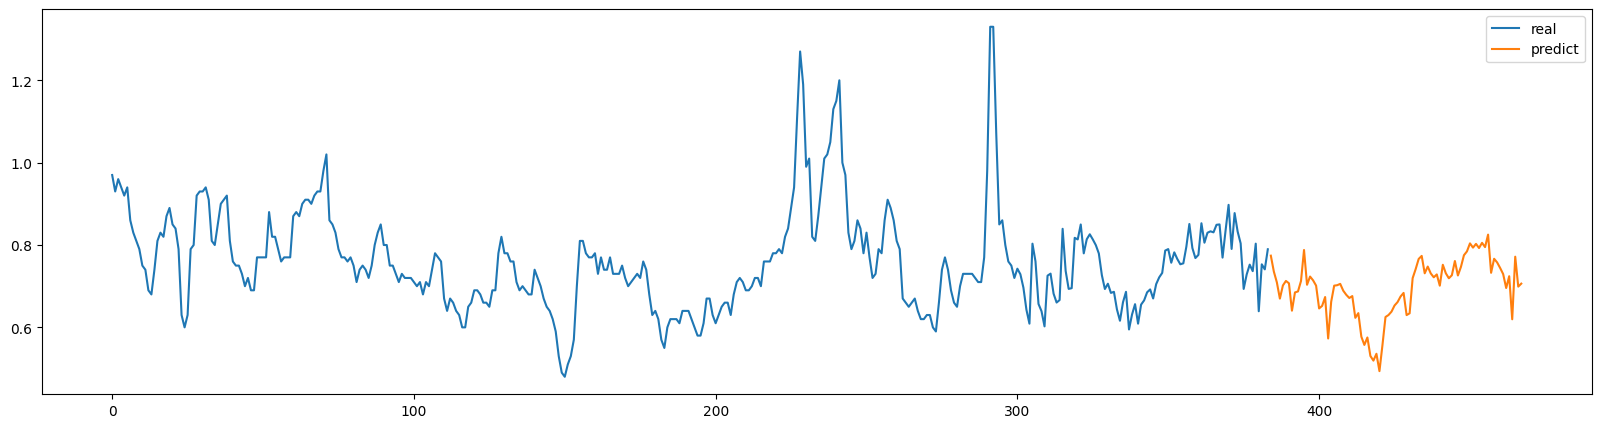

In [198]:
for targetName in tqdm(target_list, leave=True):
    originData, col_list = load_train_dataset(targetName)
    print(col_list)
    data_train = originData[['date']+col_list].copy()

    enc_in = len(col_list)
    dec_in = len(col_list)
    c_out = len(col_list)

    start_year = 2021
    start_month = 1
    add_year = pred_len // 12
    add_month = pred_len % 12
    start_plot = 300

    learning_rate = 1e-4
    criterion =  nn.L1Loss()

    # pickle model
    model = pickle.load(open(f'./savedModels/informer_{targetName}_model_v4.pkl', 'rb'))
    
    # torch model
    # model = torch.load(f'./savedModels/informer_{targetName}_model.pth')
    # model.eval()

    # in: start_year, start_month, add_year, add_month, start_plot, model_optim, iter, pitcher_list, data_train, targetName, res_df // out: res_df
    res_df = InformerRes(start_year, start_month, add_year, add_month, start_plot, iter, col_list, data_train, targetName, res_df)

    res_df

In [182]:
res_df.to_csv('~/Desktop/finalCopy/0_data/newdata/gasoilprice/gas_oil_rp_v4.csv', index=False)